In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import torch.nn.functional as F

import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL

import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [2]:
class CLIPmaskLoss(torch.nn.Module):
    def __init__(self, clip_conv_layer_weights, mask):
        super(CLIPmaskLoss, self).__init__()
        self.clip_conv_layer_weights = clip_conv_layer_weights
        self.clip_rn_layer_weights = [0,0,1.0,1.0,0]
        device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
        self.clip_model_name = "ViT-B/32"
        self.clip_for_model_name = "RN101"
        
        self.device = device
        self.num_augs = 4
        
        self.clip_conv_loss_type = "Cos"
        self.clip_fc_loss_type = "Cos"  # args.clip_fc_loss_type
        
        self.mask = mask
        if mask is not None:
            self.mask = torch.cat([mask, mask, mask], axis=0).to(device)
        
        self.valid_models = [
            "RN50",
            "RN101",
            "RN50x4",
            "RN50x16",
            "ViT-B/32",
            "ViT-B/16",
        ]
        assert self.clip_model_name in self.valid_models and self.clip_for_model_name in self.valid_models
        self.distance_metrics = \
            {
                "L2": l2_layers,
                "L1": l1_layers,
                "Cos": cos_layers
            }
        
        # background model (ViT)
        self.model, clip_preprocess = clip.load(
            self.clip_model_name, device, jit=False)
        self.model.eval()
        if self.clip_model_name.startswith("ViT"):
            self.visual_encoder = CLIPVisualEncoder(self.model)
        
#         # foreground model (RN101 - clipasso)
#         self.for_model, for_clip_preprocess = clip.load(
#             self.clip_for_model_name, device, jit=False)
#         self.for_model.eval()
        
#         self.visual_model = self.for_model.visual
#         layers = list(self.for_model.visual.children())
#         init_layers = torch.nn.Sequential(*layers)[:8]
#         self.layer1 = layers[8]
#         self.layer2 = layers[9]
#         self.layer3 = layers[10]
#         self.layer4 = layers[11]
#         self.att_pool2d = layers[12]

        # self.args = args

        self.img_size = clip_preprocess.transforms[1].size
        
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
        ])  # clip normalisation
        self.normalize_transform = transforms.Compose([
            # clip_preprocess.transforms[0],  # Resize
            # clip_preprocess.transforms[1],  # CenterCrop
            clip_preprocess.transforms[-1],  # Normalize
        ])        
        
        augemntations = []
        augemntations.append(transforms.RandomPerspective(
            fill=0, p=1.0, distortion_scale=0.5))
        augemntations.append(transforms.RandomResizedCrop(
            224, scale=(0.4, 0.9), ratio=(1.0, 1.0)))
        
        self.augment_trans = transforms.Compose(augemntations)
        self.clip_fc_layer_dims = None  # self.args.clip_fc_layer_dims
        self.clip_conv_layer_dims = None  # self.args.clip_conv_layer_dims
        self.clip_fc_loss_weight = 0
        self.counter = 0

    def forward(self, sketch, target, mode="train"):
        """
        Parameters
        ----------
        sketch: Torch Tensor [1, C, H, W]
        target: Torch Tensor [1, C, H, W]
        """
        conv_loss_dict = {}
        
        x = sketch.to(self.device)
        y = target.to(self.device)
        if self.mask is not None:
            sketch_augs, img_augs, masks = [x], [y], [self.mask.unsqueeze(dim=0)]
            if mode == "train":
                for n in range(self.num_augs):
                    augmented_pair = self.augment_trans(torch.cat([x, y, self.mask.unsqueeze(dim=0)]))
                    sketch_augs.append(augmented_pair[0].unsqueeze(0))
                    img_augs.append(augmented_pair[1].unsqueeze(0))
                    masks.append(augmented_pair[2].unsqueeze(0))
            xs = torch.cat(sketch_augs, dim=0).to(self.device)
            ys = torch.cat(img_augs, dim=0).to(self.device)
            masks = torch.cat(masks, dim=0).to(self.device)
            masks[masks < 0.5] = 0
            masks[masks >= 0.5] = 1
        else:
            sketch_augs, img_augs = [x], [y]
            if mode == "train":
                for n in range(self.num_augs):
                    augmented_pair = self.augment_trans(torch.cat([x, y]))
                    sketch_augs.append(augmented_pair[0].unsqueeze(0))
                    img_augs.append(augmented_pair[1].unsqueeze(0))
            xs = torch.cat(sketch_augs, dim=0).to(self.device)
            ys = torch.cat(img_augs, dim=0).to(self.device)
            masks = None
        
        # background pass
        xs_back = xs
        ys_back = ys
        # xs_back = self.normalize_transform(xs)
        # ys_back = self.normalize_transform(ys)
        xs_fc_features, xs_conv_features = self.visual_encoder(xs_back, masks)
        ys_fc_features, ys_conv_features = self.visual_encoder(ys_back, masks)
        conv_loss = self.distance_metrics[self.clip_conv_loss_type](
            xs_conv_features, ys_conv_features, self.clip_model_name)
        for layer, w in enumerate(self.clip_conv_layer_weights):
            if w:
                conv_loss_dict[f"clip_conv_loss_layer{layer}"] = conv_loss[layer] * w
        
        
        # # foreground pass
        # xs_for = xs * (1 - masks) + masks
        # ys_for = ys * (1 - masks) + masks
        # xs_for = self.normalize_transform(xs_for)
        # ys_for = self.normalize_transform(ys_for)
        # xs_fc_features_for, xs_conv_features_for = self.forward_inspection_clip_resnet(
        #     xs_for.contiguous())
        # ys_fc_features_for, ys_conv_features_for = self.forward_inspection_clip_resnet(
        #     ys_for.detach())
        # conv_loss_for = self.distance_metrics[self.clip_conv_loss_type](
        #     xs_conv_features_for, ys_conv_features_for, self.clip_for_model_name)
        # for layer, w in enumerate(self.clip_rn_layer_weights):
        #     if w:
        #         conv_loss_dict[f"clip_rn_loss_layer{layer}"] = conv_loss_for[layer] * w
        
        
        self.counter += 1
        # print(conv_loss_dict)
        return conv_loss_dict

    def forward_inspection_clip_resnet(self, x):
        def stem(m, x):
            for conv, bn in [(m.conv1, m.bn1), (m.conv2, m.bn2), (m.conv3, m.bn3)]:
                x = m.relu(bn(conv(x)))
            x = m.avgpool(x)
            return x
        x = x.type(self.visual_model.conv1.weight.dtype)
        x = stem(self.visual_model, x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        y = self.att_pool2d(x4)
        return y, [x, x1, x2, x3, x4]


def l2_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.square(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def l1_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.abs(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def cos_layers(xs_conv_features, ys_conv_features, clip_model_name):
    if "RN" in clip_model_name:
        return [torch.square(x_conv, y_conv, dim=1).mean() for x_conv, y_conv in
                zip(xs_conv_features, ys_conv_features)]
    return [(1 - torch.cosine_similarity(x_conv, y_conv, dim=-1)).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


class CLIPVisualEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.featuremaps = None
        self.mask_latent = False

        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.clip_model.visual.transformer.resblocks[i].register_forward_hook(
                self.make_hook(i))

    def make_hook(self, name):
        def hook(module, input, output):
            if len(output.shape) == 3:
                self.featuremaps[name] = output.permute(
                    1, 0, 2)  # LND -> NLD bs, smth, 768
            else:
                self.featuremaps[name] = output

        return hook

    def forward(self, x, masks=None):
        # masks = 1 - masks
        if masks is not None:
            x_copy = x.detach().clone()
            n_channels, kernel_h, kernel_w, step = 3, 32, 32, 32
            num_patches = 49
            patches_x = x_copy.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 
            # shape is (batch_size, channel, num_patches, patch_size, patch_size) = (5, 3, 49, 32, 32)

            patches_mask = masks.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 

            masks_ = torch.ones((5,1,7,7)).cuda()
            for i in range(masks.shape[0]):
                for j in range(num_patches):
                    zeros = (patches_mask[i, 0, j] == 0).sum() / (kernel_w * kernel_h)
                    # print(zeros)
                    if zeros > 0.2:
                        masks_[i, :, j // 7, j % 7] = 0

        
        # plt.figure(figsize=(10,20))
        # grid = make_grid(patches_x[1].permute(1,0,2,3).cpu().clone().detach(), normalize=True, pad_value=0, nrow=7)
        # npgrid = grid.cpu().numpy().astype(np.float32)
        # plt.subplot(1,3,1)
        # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        # plt.axis("off")
        # grid = make_grid(patches_mask[1].permute(1,0,2,3).cpu().clone().detach(), normalize=True, pad_value=0, nrow=7)
        # npgrid = grid.cpu().numpy().astype(np.float32)
        # plt.subplot(1,3,2)
        # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        # plt.axis("off")
        # plt.subplot(1,3,3)
        # grid = make_grid(masks_, normalize=True, pad_value=0, nrow=7)
        # npgrid = grid.cpu().numpy().astype(np.float32)
        # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        # # plt.axis("off")
        # plt.show()
        # plt.close()
        
        if self.mask_latent:
            # masks_ = table_per.cuda()#torch.nn.functional.interpolate(masks, size=7, mode='nearest')
            # print(masks_.shape)
            # masked_inds = (masks_ == 0).nonzero(as_tuple=False)
            # print(masked_inds.shape)
            
            # plt.figure(figsize=(10,20))
            # grid = make_grid((torch.nn.functional.interpolate(masks, size=224, mode='nearest') * x_copy).clone().detach(), normalize=True, pad_value=0)
            # npgrid = grid.cpu().numpy().astype(np.float32)
            # # plt.subplot(13,1,1)
            # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
            # plt.axis("off")
            # plt.show()
            # plt.close()
            masks_flat = masks_[:,0].reshape(-1, 49)#.to(device) shape (5, 49)

            indixes = (masks_flat == 0).nonzero() # shape [136, 2] [[aug_im],[index]]

            for t in indixes:
                b_num, y, x_ = t[0], t[1] // 7, t[1] % 7
                x_copy[b_num, :, 32 * y: 32 * y + 32, 32 * x_: 32 * x_ + 32] = 0
            # plt.figure(figsize=(10,20))
            # grid = make_grid((x_copy).detach(), normalize=True, pad_value=0)
            # npgrid = grid.cpu().numpy().astype(np.float32)
            # # plt.subplot(13,1,1)
            # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
            # plt.axis("off")
            # plt.show()
            # plt.close()
            # print("before cls", masks_flat.shape)
            masks_flat = torch.cat([torch.ones(masks_flat.shape[0],1).to(device), masks_flat], dim=1)
            # print("after cls1", masks_flat.shape)
            masks_flat = masks_flat.unsqueeze(2).repeat(1, 1, 768)
            # print("after cls2", masks_flat.shape)

            # print("masks_flat",masks_flat.shape)
        self.featuremaps = collections.OrderedDict()
        fc_features = self.clip_model.encode_image(x).float()
        # featuremaps = [self.featuremaps[k] * masks_flat for k in range(12)]
        featuremaps = [self.featuremaps[k] for k in range(12)]


        # each featuremap is in shape (5,50,768) - 5 is the batchsize(augment), 50 is 49 patches + cls, 768 is the features
        # print("f shape")
        # plt.figure(figsize=(10,20))
        # grid = make_grid(x.clone().detach(), normalize=True, pad_value=2)
        # npgrid = grid.cpu().numpy().astype(np.float32)
        # plt.subplot(13,1,1)
        # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        # plt.axis("off")
        if masks is not None:
            for i in range(12):
                f_0 = featuremaps[i]
                # f_0 = (f_0 - f_0.min()) / (f_0.max() - f_0.min())
                f_0 = f_0 * masks_flat

                f_0 = f_0.mean(axis=-1)
                # print("mean", f_0.shape)
                cams_avg = f_0[:, 1:] # 5, 49
                # cams_avg = (cams_avg - cams_avg.min()) / (cams_avg.max() - cams_avg.min()) 
                # cams_avg =cams_avg * masks_flat
                # mask = torch.ones(cams_avg.shape).to(device)
                # mask[:,0] = 0
                # print("cams_avg", cams_avg.shape)
                image_relevance = cams_avg.reshape(-1, 224 // 32, 224 // 32).unsqueeze(1)
                # mask = mask.reshape(-1, 224 // 32, 224 // 32).unsqueeze(1)
                # print("image_relevance", image_relevance.shape)
                # print("min", image_relevance.min())
                image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='nearest')
                # print("min", image_relevance.min())

                # mask = torch.nn.functional.interpolate(mask, size=224, mode='nearest')
                # print("image_relevance", image_relevance.shape)
                # image_relevance = image_relevance.reshape(5,1,224, 224).data.cpu().numpy().astype(np.float32)
                # print("image_relevance", image_relevance.shape)

                # image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min()) 
                # print("min", image_relevance.min())

            #     grid = make_grid(image_relevance.clone().detach(), normalize=True, pad_value=0)
            #     npgrid = grid.cpu().numpy()#.astype(np.float32)
            #     # npgrid = (npgrid - npgrid.min()) / (npgrid.max() - npgrid.min())
            #     plt.subplot(13,1,i + 2)
            #     # print("npgrid", npgrid.max(), npgrid.min(), npgrid.dtype)
            #     plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
            #     plt.axis("off")
            # plt.show()
            # plt.close()
    #     cams_avg = torch.cat(cams) # 12, 50, 50
    # cams_avg = cams_avg[:, 0, 1:] # 12, 1, 49
    # image_relevance = cams_avg.mean(dim=0).unsqueeze(0)
    # image_relevance = image_relevance.reshape(1, 1, 224 // pathces_num, 224 // pathces_num)
    # image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bicubic')
    # image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy().astype(np.float32)
    # image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    # return image_relevance, cams_avg, R
    #     print(featuremaps[0].shape, featuremaps[-1].shape)

        return fc_features, featuremaps

In [82]:
def get_initial_points(path_svg, target_="", device=None):
    # target = torch.from_numpy(skimage.io.imread(target_)).to(torch.float32) / 255.0
    # # target = target.pow(gamma)
    # target = target.to(pydiffvg.get_device())
    # target = target.unsqueeze(0)
    # target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    # print("all_points", all_points)
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        width = torch.tensor(1.0)
        if widths is not None:
            width = widths[p]
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=width, is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    # masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, None#mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    # if is_cuda:
    #     U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False, latent_dim=5, categorical_dim=2):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(latent_dim, categorical_dim)
    
def optimize_through_net(target, points_vars, mlp, mlp_opt, mlp_width, optimizer_width, loss_clip, device, width_weight=0.0, canvas_size=224, num_strokes=32, num_cp=4, only_width=False, num_iter=10, print_int=10):
    # widths = torch.ones((num_strokes)).to(device)
    # widths = torch.rand((num_strokes)).to(device)
    init_width = torch.ones((num_strokes)).to(device) * 1.5
    # widths = 2*widths-1
    widths = init_width

    # widths = torch.zeros((num_strokes)).to(device)
    losses_clip = []
    losses_width = []
    lowest_loss = 100
    best_iter = 0
    best_im = None
    best_num_strokes = num_strokes
    zero = torch.tensor(0).to(device)
    # widths = torch.rand((num_strokes)).to(device)
    for t in range(num_iter):
        if not only_width:
            mlp_opt.zero_grad()
        optimizer_width.zero_grad()
        
        if widths is not None:
            widths_ = mlp_width(widths)
            mask_flipped = 1 - widths_
            v = torch.stack((torch.log(widths_), torch.log(mask_flipped)), dim=-1)
            hard_mask = torch.nn.functional.gumbel_softmax(v, 0.2, False)
            new_mask = hard_mask[:, 0] * init_width
            # print(hard_mask[:, 0].shape)
        # new_mask = widths
        # with torch.no_grad():
        #     points = mlp(points_vars, None)
        if not only_width:
            points = mlp(points_vars, None)
            # print(points[0])
        else:
            points = points_vars
        img_ = render_points(points, new_mask, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)  
        # plt.imshow(img_.cpu().detach().numpy())
        # plt.show()
        # plt.close()
        img = img_[:, :, :3]
        # Convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
        
        # sketch, target
        loss_clip_ = loss_clip(img, target, mode="train")      

        sum_w = torch.sum(hard_mask[:, 0])
        # mini_loss = width_weight * sum_w  # minimal sum
        
        mini_loss = torch.max(zero, sum_w - width_weight)
        # k_loss = 0 * (torch.sum(hard_mask[:, 0]) - k) ** 2  # choose only k values
        
        loss_clip_sum = sum(list(loss_clip_.values()))
        
        loss =  loss_clip_sum +  mini_loss
        losses_clip.append(loss_clip_sum.item())
        losses_width.append(mini_loss.item())
        
        loss.backward()
        if not only_width:
            mlp_opt.step()
        optimizer_width.step()
        
        if loss.item() <= lowest_loss:
            best_im = img_
            lowest_loss = loss.item()
            best_iter = t
            best_num_strokes = sum_w.item()
    # plt.show()
    # plt.close()
    points = mlp(points_vars)
    img = render_points(points, new_mask, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    return img, best_im, losses_clip, losses_width, best_iter, best_num_strokes

In [80]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        # num_strokes = 32
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )
        
        # self.layers_width = nn.Sequential(
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.Sigmoid()
        # )


    def forward(self, x, widths=None):
        '''Forward pass'''
        deltas = self.layers(x)
        # print(deltas.shape)
        # print(x.flatten().shape)
        # if widths is not None:
        #     return x.flatten() + 0.1 * deltas, self.layers_width(widths)
        return x.flatten() + 0.1 * deltas

class MLPWidth(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        self.num_strokes = num_strokes
        outdim = 1000
        # num_strokes = 32        
        self.layers_width = nn.Sequential(
            nn.Linear(num_strokes, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, num_strokes),
            nn.Sigmoid()
        )


    def forward(self, widths=None):
        '''Forward pass'''
        res = self.layers_width(widths)#.view(self.num_strokes, 2)
        # print(res.shape)
        return res
        

Cos_mlp_ViT_l4_32s_semi-complex_mask_seed0


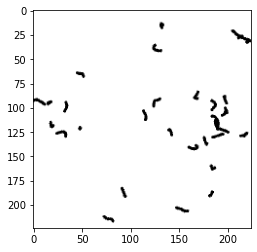

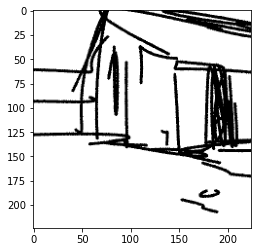

4
time: 40.84826874732971


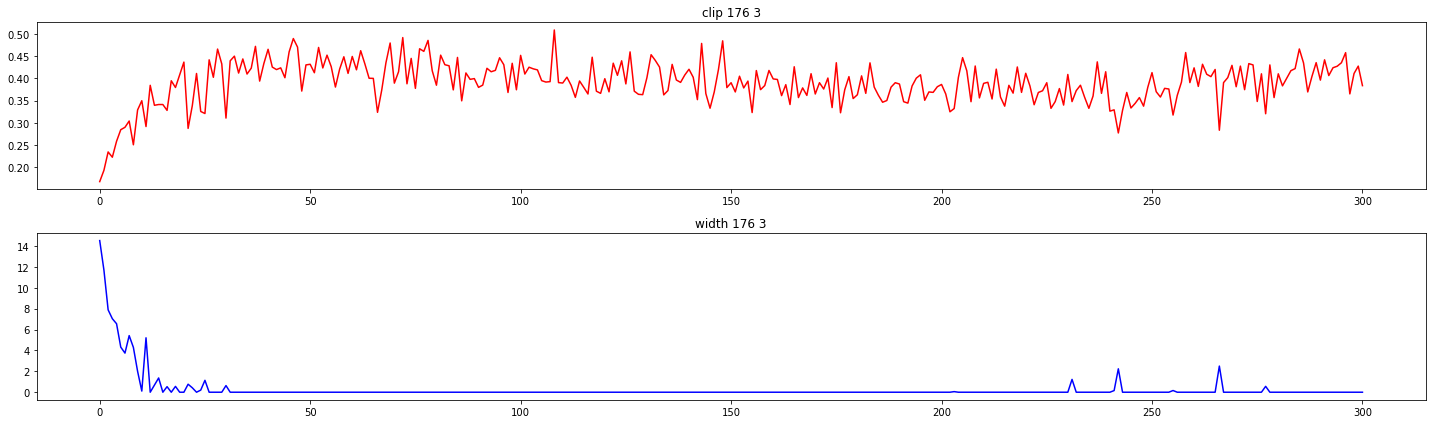

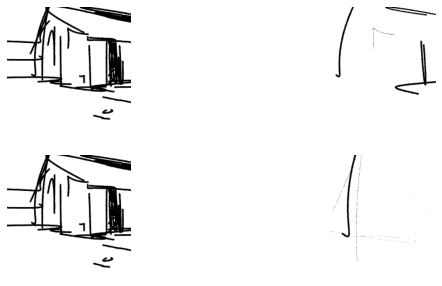

In [85]:
# tests
import time

# random.seed(0)
# np.random.seed(0)
# # os.environ['PYTHONHASHSEED'] = str(seed)
# torch.manual_seed(0)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]

im_name = "semi-complex_mask"
# im_name = "complex-scene-crop_mask"

# layers = [3,4,5,6,7,8,9,10,11]
layers = [4]
weights = np.array([31, 16, 8, 4]) 
weights = np.array([4]) 


# weights = np.array([0.0001, 0.0004, 0.0008, 0.001]) 
canvas_size=224
num_strokes=32
num_cp=4

num_iter=301
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex_mask.png"
all_arr = []
for layer in layers:
    # im_name = "complex-scene-crop_mask"
    path_res = f"/home/vinker/dev/background_project/experiements/mlp_19_06/Cos_mlp_ViT_l{layer}_32s_{im_name}/"#best_mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter1000.svg"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"
    best_svg_folder = svg_filename[:-9]
    print(best_svg_folder)
    mlp_path = f"{path_res}/{best_svg_folder}/mlp.pth"
    svg_init_path = f"{path_res}/{best_svg_folder}/svg_logs/svg_iter0.svg"

    points_vars = get_initial_points(svg_init_path, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2*points_vars-1
    

    widths = torch.ones(num_strokes) * 1.5
    # im1 = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)

#     imageio.imsave(f"house_layer{layer}.png", im1.detach().cpu().numpy())
    target_ = f"house_layer{layer}.png"
    target, mask = get_target(target_, device, image_scale=224)
    
    clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
    clip_conv_layer_weights[4] = 1
    loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    
    checkpoint = torch.load(mlp_path)
    # start_epoch = checkpoint['epoch']
    mlp.load_state_dict(checkpoint)
    with torch.no_grad():
        points_vars = mlp(points_vars, None)
    
    
    # points = mlp(points_vars, None)
    img_ = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    plt.imshow(img_.cpu().detach().numpy())
    plt.show()
    
    mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # mlp_width.apply(init_weights)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)

    results = []
    results_f = []
    plt.figure(figsize=(20,6))
    for i, w in enumerate(weights):
        print(w)
        start = time.time()
        im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=w, canvas_size=224, num_strokes=num_strokes, num_cp=4, only_width=True, num_iter=num_iter, print_int=100)
        
        plt.subplot(2,len(weights),i + 1)
        plt.plot(range(num_iter), losses_clip, color='r')
        plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
        plt.subplot(2,len(weights),len(weights) + i + 1)
        plt.plot(range(num_iter), losses_width, color='b')
        plt.title(f"width {best_iter} {int(best_num_strokes)}")
        results.append(best_im)
        results_f.append(im)
        
        
        print("time:", time.time() - start)
        del mlp
    plt.tight_layout()
    plt.show()
    plt.close()
    all_arr.append(results)

    # plt.figure(figsize=(20,10))
    plt.figure(figsize=(10,5))
    plt.subplot(2,len(results) + 1,1)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    plt.subplot(2,len(results) + 1,len(results) + 2)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    for i, res in enumerate(results):
        plt.subplot(2,len(results) + 1,i + 2)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
        plt.subplot(2,len(results) + 1,len(results) + i + 3)
        plt.imshow(results_f[i].detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

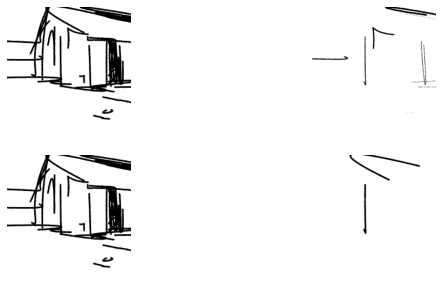

In [76]:
# plt.figure(figsize=(20,10))
plt.figure(figsize=(10,5))
plt.subplot(2,len(results) + 1,1)
plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")
plt.subplot(2,len(results) + 1,len(results) + 2)
plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")
for i, res in enumerate(results):
    plt.subplot(2,len(results) + 1,i + 2)
    plt.imshow(res.detach().cpu().numpy())
    plt.axis("off")
    plt.subplot(2,len(results) + 1,len(results) + i + 3)
    plt.imshow(results_f[i].detach().cpu().numpy())
    plt.axis("off")
plt.show()
plt.close()

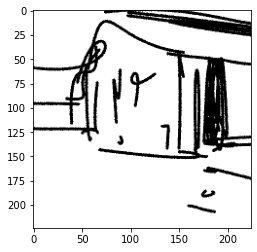

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 14.050085067749023
16
time: 14.201461791992188
8
time: 14.2703537940979
4
time: 14.003122568130493


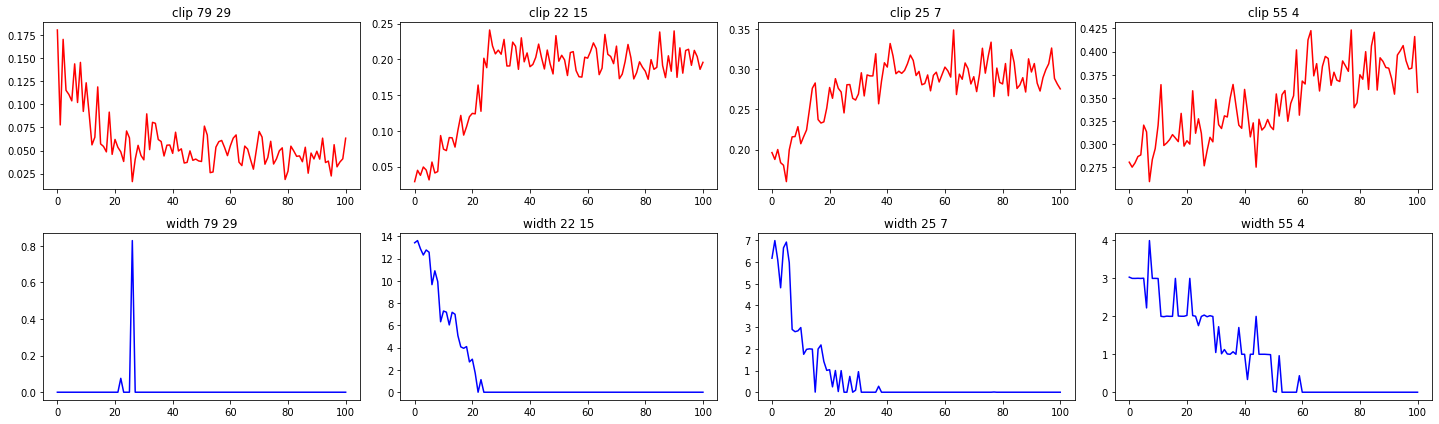

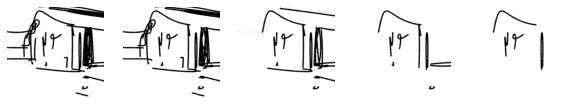

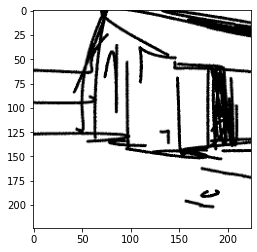

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 14.116883516311646
16
time: 14.084521532058716
8
time: 14.204529762268066
4
time: 13.930712699890137


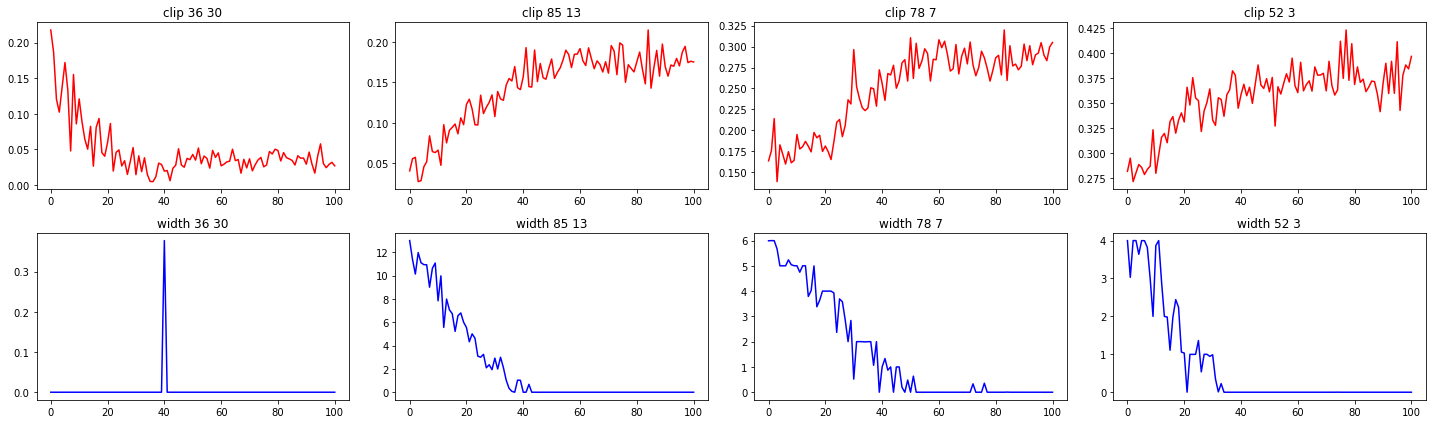

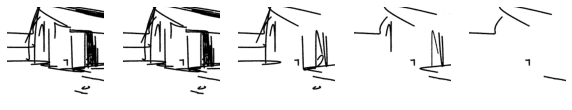

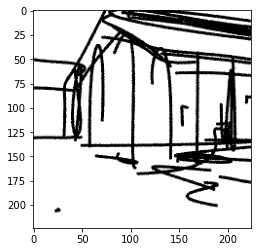

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 14.118279695510864
16
time: 14.514657020568848
8
time: 14.430153131484985
4
time: 13.817574977874756


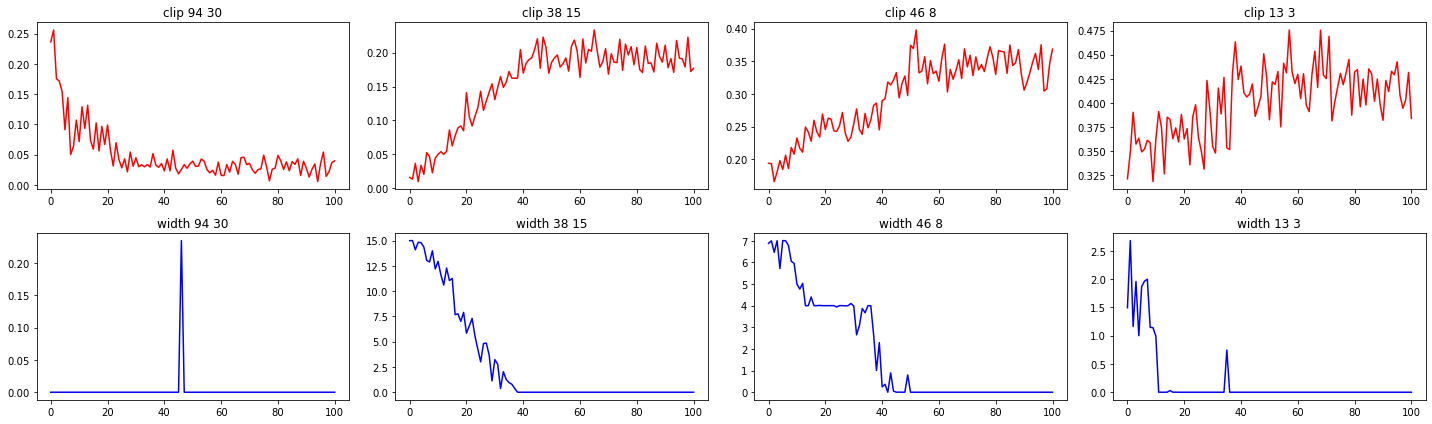

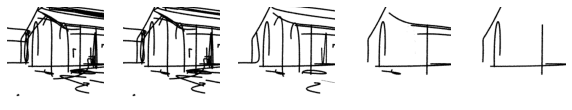

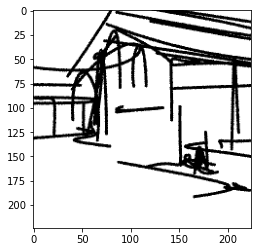

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 13.464967250823975
16
time: 14.457035541534424
8
time: 13.582681655883789
4
time: 14.297816038131714


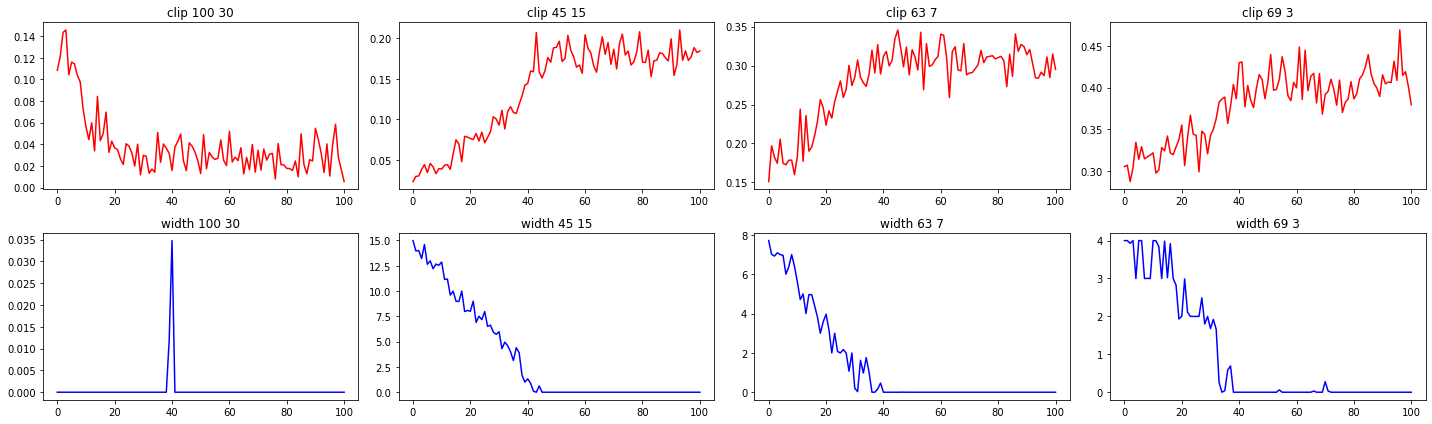

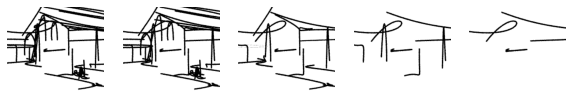

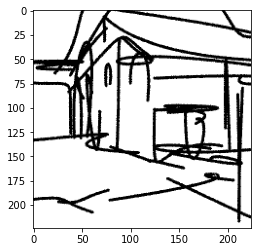

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 14.021669626235962
16
time: 14.43859601020813
8
time: 14.103310585021973
4
time: 14.418766498565674


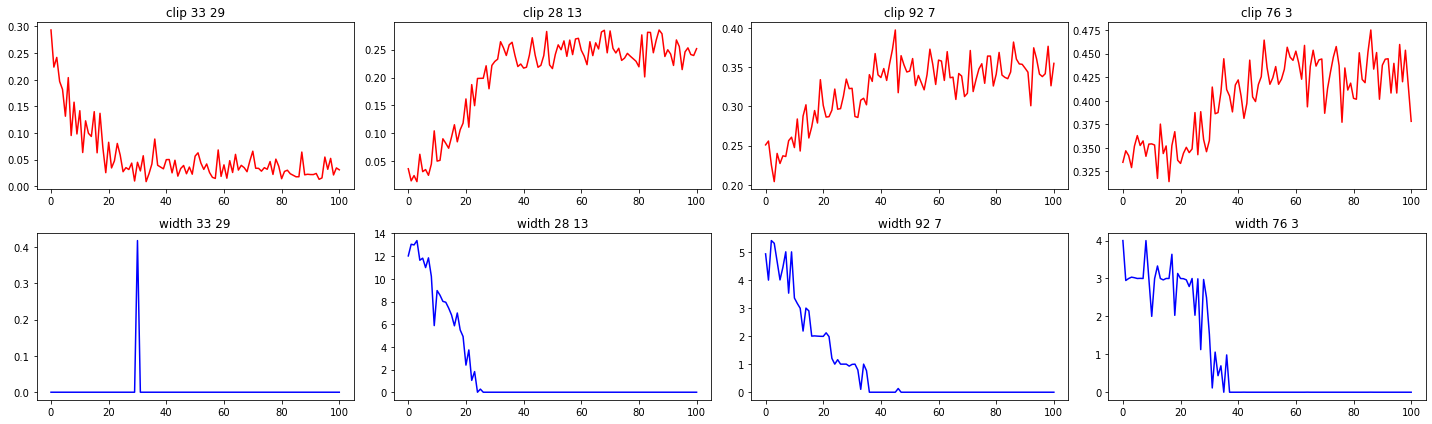

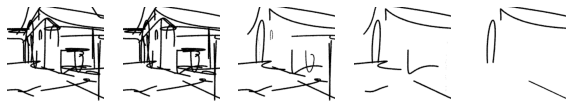

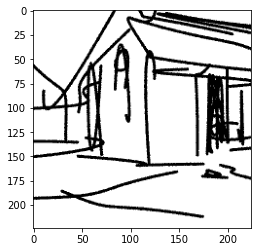

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 13.729298114776611
16
time: 13.58506178855896
8
time: 14.362562894821167
4
time: 13.981567621231079


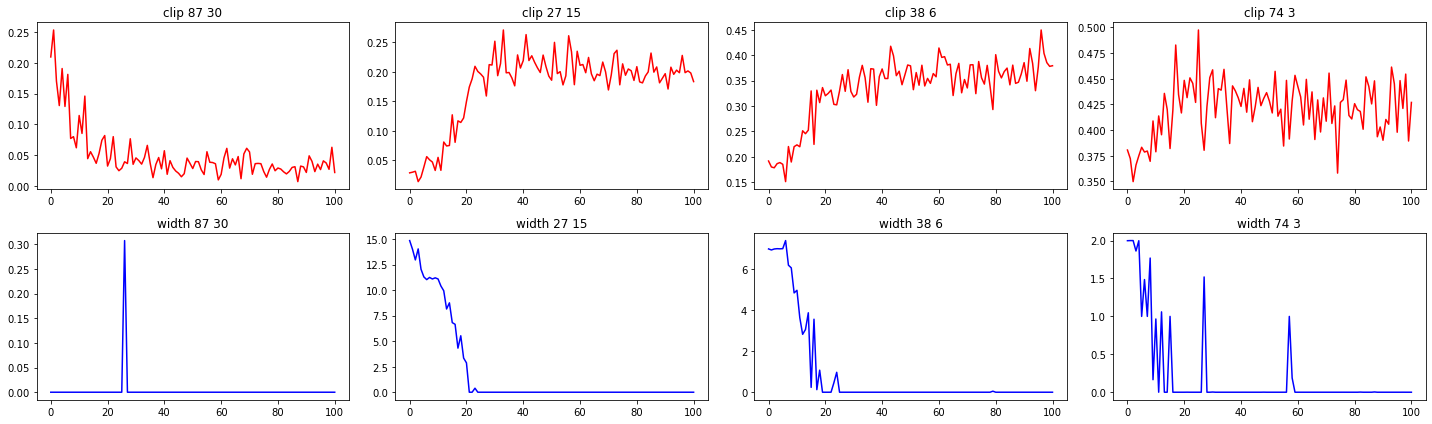

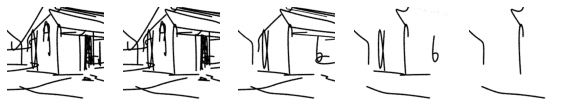

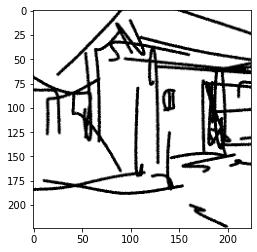

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 13.397382020950317
16
time: 13.930008888244629
8
time: 14.240106105804443
4
time: 13.176518201828003


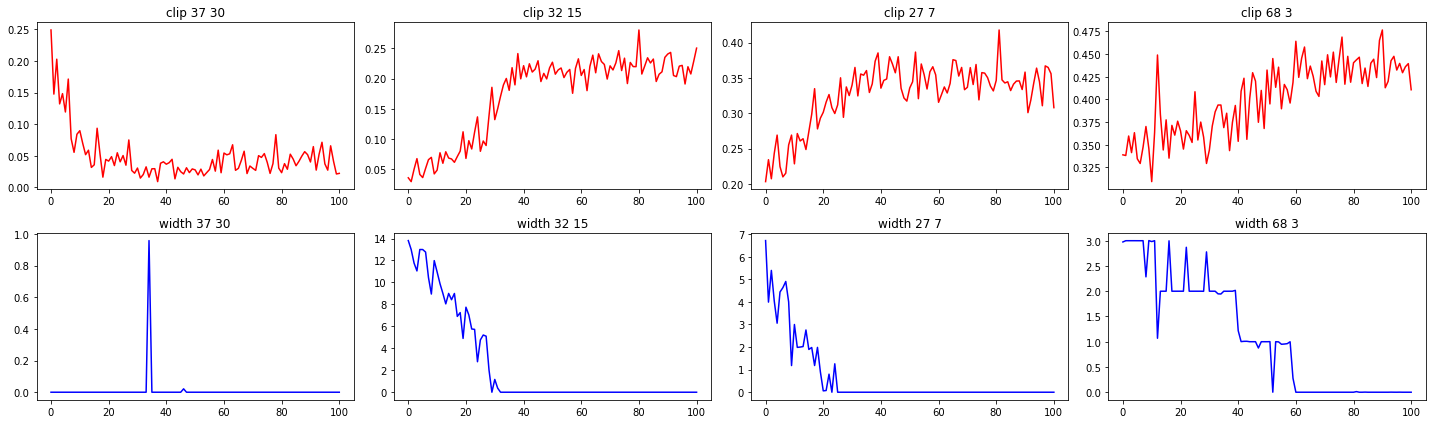

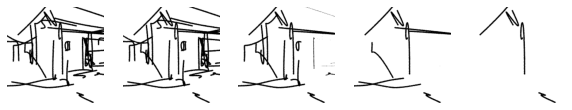

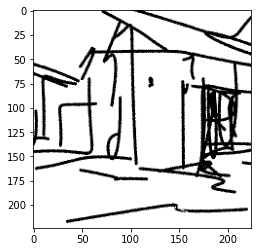

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 14.174683809280396
16
time: 13.408947467803955
8
time: 13.811553955078125
4
time: 14.10309624671936


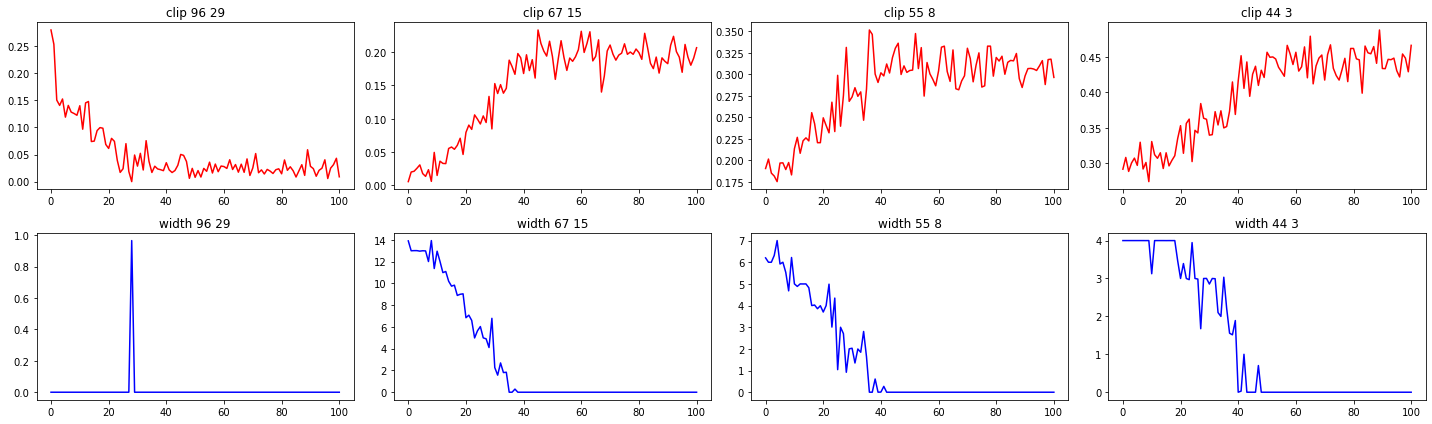

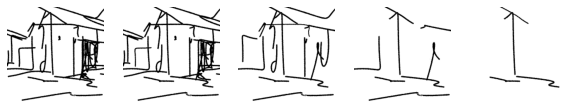

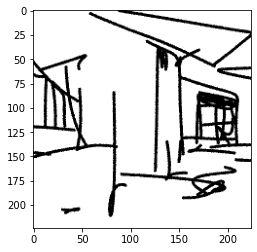

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 14.354285478591919
16
time: 14.234082221984863
8
time: 13.025429010391235
4
time: 13.621996641159058


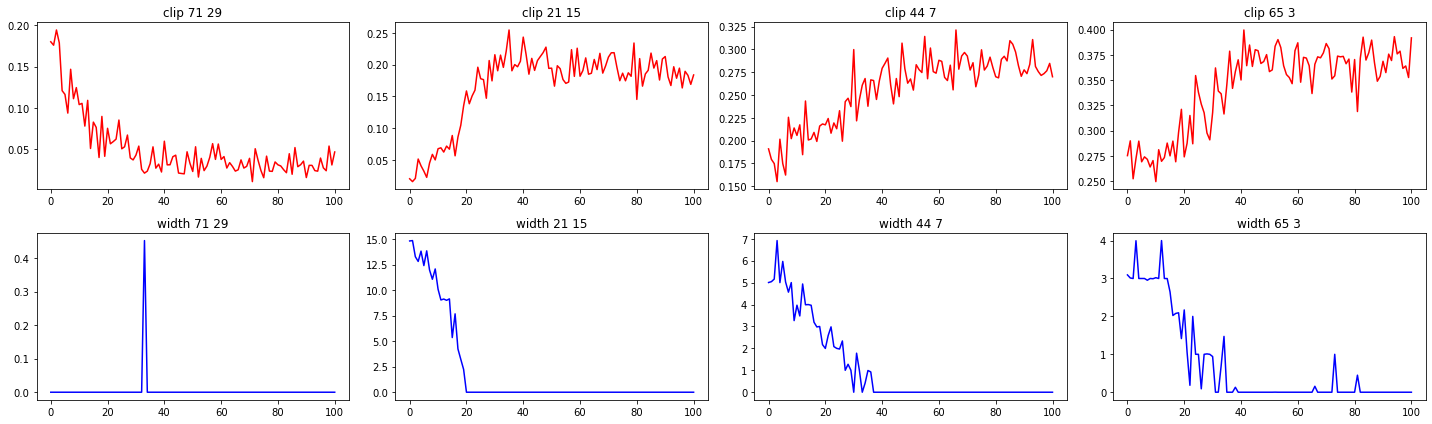

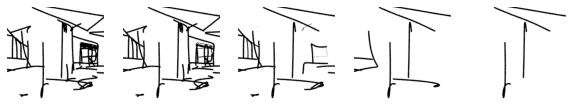

In [62]:
# tests
import time

# random.seed(0)
# np.random.seed(0)
# # os.environ['PYTHONHASHSEED'] = str(seed)
# torch.manual_seed(0)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]

im_name = "semi-complex_mask"
# im_name = "complex-scene-crop_mask"

layers = [3]#,4,5,6,7,8,9,10,11]
# layers = [11]
# weights = np.array([0.001]) 

# weights = np.array([0.0001, 0.0004, 0.0008, 0.001]) 
weights = np.array([31, 16, 8, 4]) 
canvas_size=224
num_strokes=32
num_cp=4

all_arr = []
for layer in layers:
    # im_name = "complex-scene-crop_mask"
    path_res = f"/home/vinker/dev/background_project/experiements/mlp_19_06/Cos_mlp_ViT_l{layer}_32s_{im_name}/"#best_mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter1000.svg"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"

    points_vars = get_initial_points(path_svg, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2*points_vars-1

    widths = torch.ones(num_strokes) * 1.5
    im1 = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)

    imageio.imsave(f"house_layer{layer}.png", im1.detach().cpu().numpy())
    target_ = f"house_layer{layer}.png"
    target, mask = get_target(target_, device, image_scale=224)
    
    clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
    clip_conv_layer_weights[4] = 1
    loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    mlp_width.apply(init_weights)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)
    
    results = []
    plt.figure(figsize=(20,6))
    for i, w in enumerate(weights):
        plt.subplot(1,len(weights),i + 1)
        print(w)
        start = time.time()
        im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=w, canvas_size=224, num_strokes=num_strokes, num_cp=4, only_width=True, num_iter=101, print_int=100)
        results.append(best_im)
        print("time:", time.time() - start)
        plt.subplot(2,len(weights),i + 1)
        plt.plot(range(num_iter), losses_clip, color='r')
        plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
        plt.subplot(2,len(weights),len(weights) + i + 1)
        plt.plot(range(num_iter), losses_width, color='b')
        plt.title(f"width {best_iter} {int(best_num_strokes)}")
        # del mlp
    plt.tight_layout()
    plt.show()
    plt.close()
    all_arr.append(results)

    # plt.figure(figsize=(20,10))
    plt.figure(figsize=(10,5))
    plt.subplot(1,len(results) + 1,1)
    plt.imshow(im1.detach().cpu().numpy())
    plt.axis("off")
    for i, res in enumerate(results):
        plt.subplot(1,len(results) + 1,i + 2)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

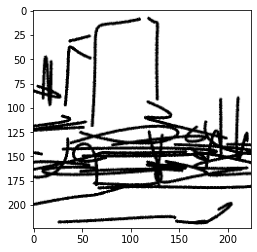

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


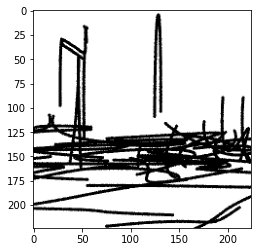

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


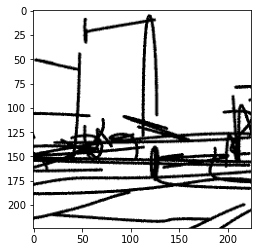

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


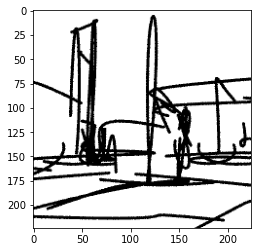

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


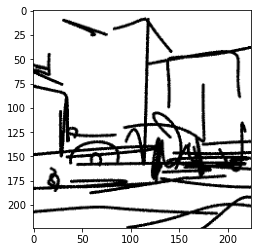

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


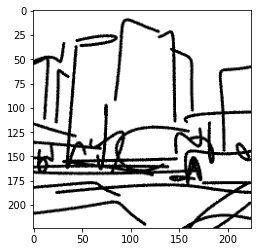

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


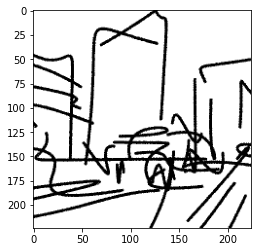

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


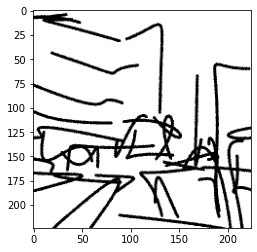

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


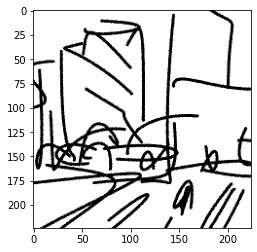

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [87]:
# tests
import time

# random.seed(0)
# np.random.seed(0)
# # os.environ['PYTHONHASHSEED'] = str(seed)
# torch.manual_seed(0)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]

im_name = "semi-complex_mask"
# im_name = "complex-scene-crop_mask"

layers = [3,4,5,6,7,8,9,10,11]
# layers = [11]
# weights = np.array([0.001]) 

# weights = np.array([0.0001, 0.0004, 0.0008, 0.001]) 
weights = np.array([31, 16, 8, 4]) 
canvas_size=224
num_strokes=32
num_cp=4

all_arr = []
for layer in layers:
    im_name = "complex-scene-crop_mask"
    path_res = f"/home/vinker/dev/background_project/experiements/mlp_19_06/Cos_mlp_ViT_l{layer}_32s_{im_name}/"#best_mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter1000.svg"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"

    points_vars = get_initial_points(path_svg, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2*points_vars-1

    widths = torch.ones(num_strokes) * 1.5
    im1 = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)

    imageio.imsave(f"buildings_layer{layer}.png", im1.detach().cpu().numpy())
    # target_ = f"house_layer{layer}.png"
#     target, mask = get_target(target_, device, image_scale=224)
    
#     clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
#     clip_conv_layer_weights[4] = 1
#     loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
#     mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
#     mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
#     def init_weights(m):
#         if isinstance(m, nn.Linear):
#             torch.nn.init.xavier_uniform_(m.weight)
#             m.bias.data.fill_(0.01)

#     mlp_width.apply(init_weights)
#     optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
#     optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)
    
#     results = []
#     plt.figure(figsize=(20,6))
#     for i, w in enumerate(weights):
#         plt.subplot(1,len(weights),i + 1)
#         print(w)
#         start = time.time()
#         im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=w, canvas_size=224, num_strokes=num_strokes, num_cp=4, only_width=True, num_iter=101, print_int=100)
#         results.append(best_im)
#         print("time:", time.time() - start)
#         plt.subplot(2,len(weights),i + 1)
#         plt.plot(range(num_iter), losses_clip, color='r')
#         plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
#         plt.subplot(2,len(weights),len(weights) + i + 1)
#         plt.plot(range(num_iter), losses_width, color='b')
#         plt.title(f"width {best_iter} {int(best_num_strokes)}")
#         # del mlp
#     plt.tight_layout()
#     plt.show()
#     plt.close()
#     all_arr.append(results)

#     # plt.figure(figsize=(20,10))
#     plt.figure(figsize=(10,5))
#     plt.subplot(1,len(results) + 1,1)
#     plt.imshow(im1.detach().cpu().numpy())
#     plt.axis("off")
#     for i, res in enumerate(results):
#         plt.subplot(1,len(results) + 1,i + 2)
#         plt.imshow(res.detach().cpu().numpy())
#         plt.axis("off")
#     plt.show()
#     plt.close()

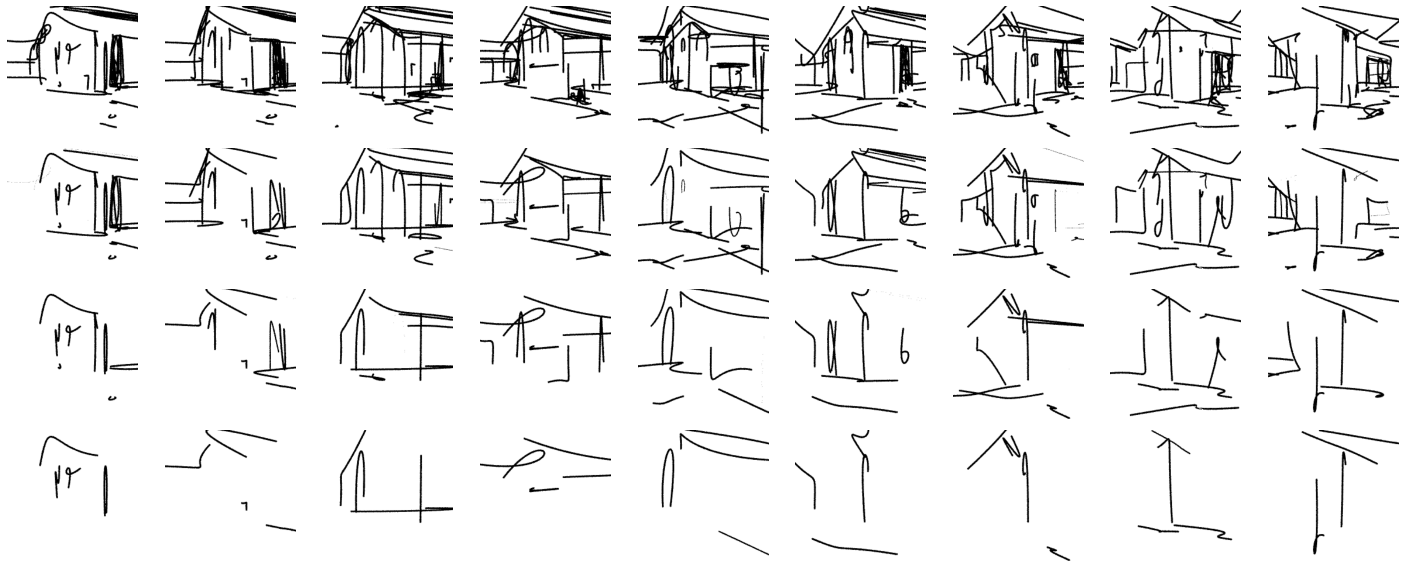

In [63]:
plt.figure(figsize=(20,8))
for i, layer_res, layer_ in zip(range(len(all_arr)), all_arr, layers):
    im_name = f"house_layer{layer_}.png"
    im_cur = Image.open(im_name)
    plt.subplot(len(weights),len(layers),i + 1)
    plt.imshow(im_cur)
    plt.axis("off")
    for j, res in enumerate(layer_res):
        # print(len(weights),len(layers),(j + 1) * len(layers) + i)
        plt.subplot(len(weights),len(layers), (j) * len(layers) + i + 1)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
plt.tight_layout()
plt.show()

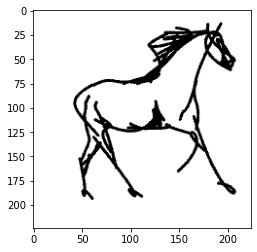

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31
time: 13.538828611373901
24
time: 14.024837970733643
16
time: 13.2841317653656
8
time: 14.07465648651123


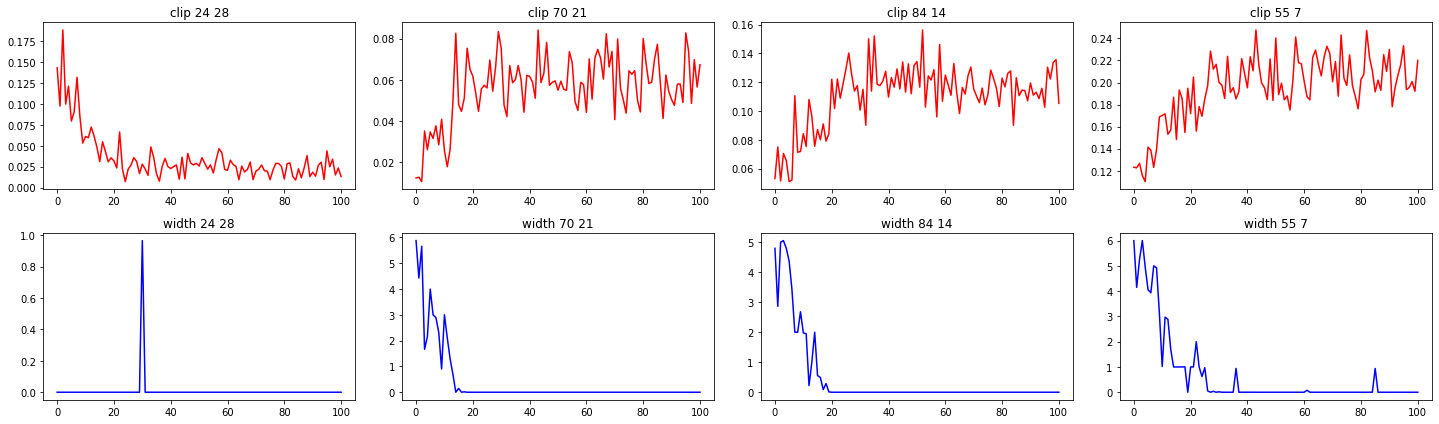

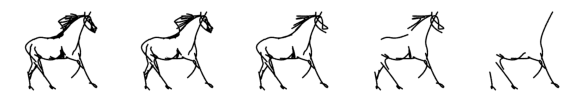

In [93]:
# tests
import time

# random.seed(0)
# np.random.seed(0)
# # os.environ['PYTHONHASHSEED'] = str(seed)
# torch.manual_seed(0)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]

im_name = "semi-complex_mask"
# im_name = "complex-scene-crop_mask"

# layers = [3,4,5,6,7,8,9,10,11]
layers = [11]
# weights = np.array([0.001]) 

# weights = np.array([0.0001, 0.0004, 0.0008, 0.001]) 
weights = np.array([31, 24, 16, 8]) 
canvas_size=224
num_strokes=32
num_cp=4
num_iter=101

all_arr = []
for layer in layers:
    # im_name = "complex-scene-crop_mask"
    # path_res = f"/home/vinker/dev/background_project/experiements/mlp_19_06/Cos_mlp_ViT_l{layer}_32s_{im_name}/"#best_mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter1000.svg"
    path_res = "/home/vinker/dev/background_project/experiements/05_29_image_divide/baseline_easy-background-crop_32s/"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"

    points_vars = get_initial_points(path_svg, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2*points_vars-1

    widths = torch.ones(num_strokes) * 1.5
    im1 = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)

    imageio.imsave(f"horse_easy.png", im1.detach().cpu().numpy())
    target_ = f"horse_easy.png"
    
    target, mask = get_target(target_, device, image_scale=224)
    
    clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
    clip_conv_layer_weights[4] = 1
    loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    mlp_width.apply(init_weights)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)
    
    results = []
    plt.figure(figsize=(20,6))
    for i, w in enumerate(weights):
        plt.subplot(1,len(weights),i + 1)
        print(w)
        start = time.time()
        im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=w, canvas_size=224, num_strokes=num_strokes, num_cp=4, only_width=True, num_iter=num_iter, print_int=100)
        results.append(best_im)
        print("time:", time.time() - start)
        plt.subplot(2,len(weights),i + 1)
        plt.plot(range(num_iter), losses_clip, color='r')
        plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
        plt.subplot(2,len(weights),len(weights) + i + 1)
        plt.plot(range(num_iter), losses_width, color='b')
        plt.title(f"width {best_iter} {int(best_num_strokes)}")
        # del mlp
    plt.tight_layout()
    plt.show()
    plt.close()
    all_arr.append(results)

    # plt.figure(figsize=(20,10))
    plt.figure(figsize=(10,5))
    plt.subplot(1,len(results) + 1,1)
    plt.imshow(im1.detach().cpu().numpy())
    plt.axis("off")
    for i, res in enumerate(results):
        plt.subplot(1,len(results) + 1,i + 2)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

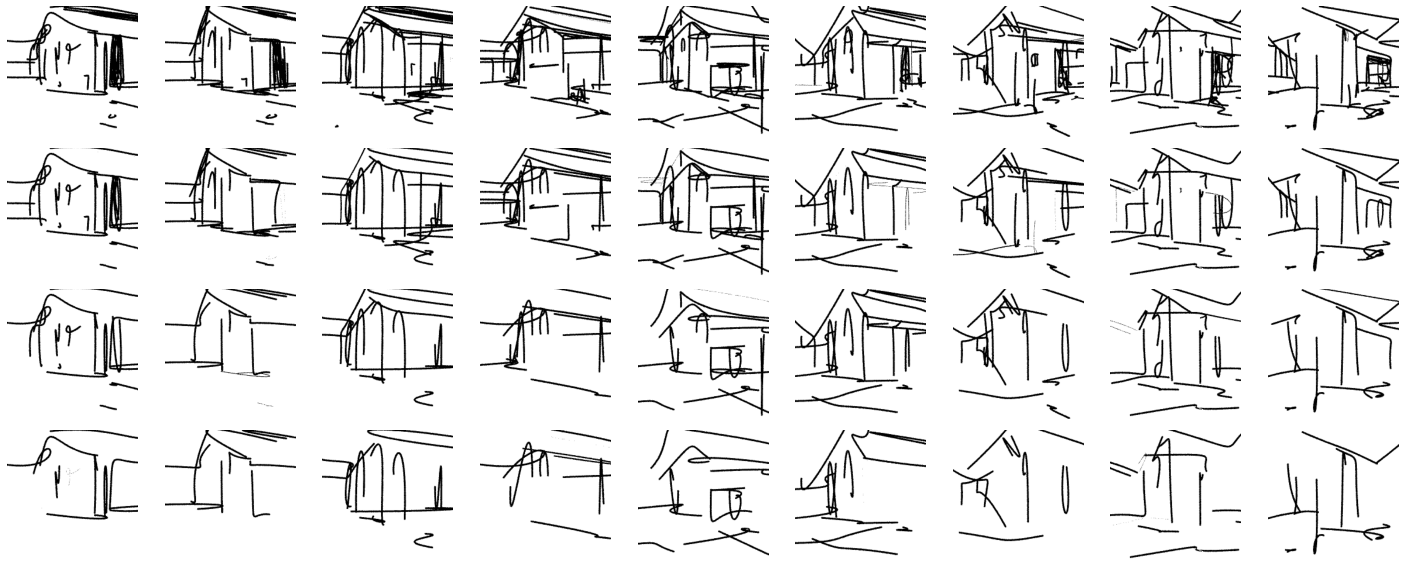

In [102]:
plt.figure(figsize=(20,8))
for i, layer_res, layer_ in zip(range(len(all_arr)), all_arr, layers):
    im_name = f"house_layer{layer_}.png"
    im_cur = Image.open(im_name)
    plt.subplot(len(weights),len(layers),i + 1)
    plt.imshow(im_cur)
    plt.axis("off")
    for j, res in enumerate(layer_res):
        # print(len(weights),len(layers),(j + 1) * len(layers) + i)
        plt.subplot(len(weights),len(layers), (j) * len(layers) + i + 1)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
plt.tight_layout()
plt.show()

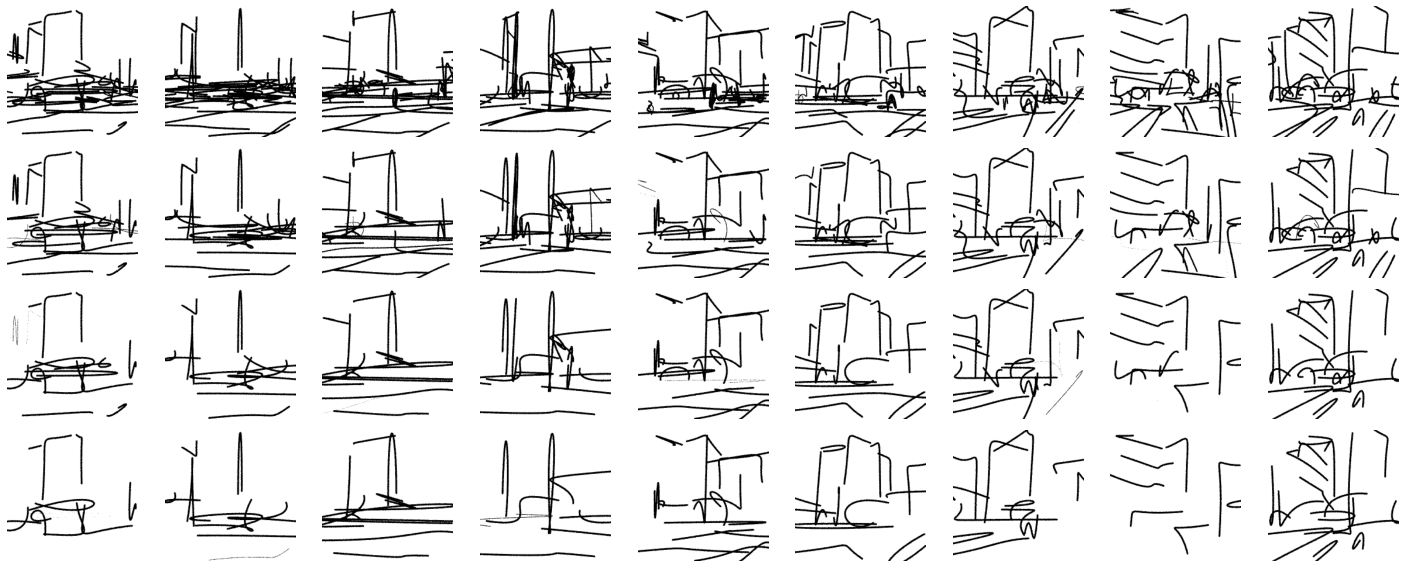

In [104]:
plt.figure(figsize=(20,8))
for i, layer_res, layer_ in zip(range(len(all_arr)), all_arr, layers):
    im_name = f"house_layer{layer_}.png"
    im_cur = Image.open(im_name)
    plt.subplot(len(weights),len(layers),i + 1)
    plt.imshow(im_cur)
    plt.axis("off")
    for j, res in enumerate(layer_res):
        # print(len(weights),len(layers),(j + 1) * len(layers) + i)
        plt.subplot(len(weights),len(layers), (j) * len(layers) + i + 1)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# genrate_vid



(5, 4, 2)


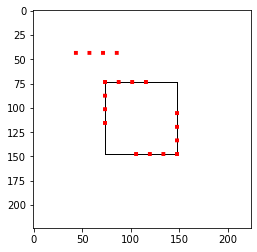

torch.Size([1, 5, 4, 2])


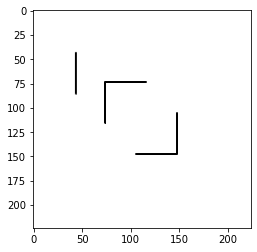

iteration: 0


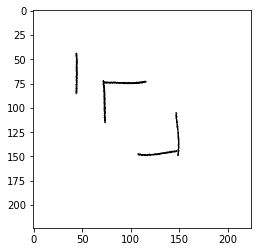

render loss: 0.05485142022371292 mini_loss 0.00046909492812119424
iteration: 10


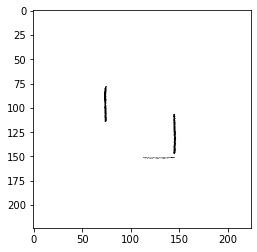

render loss: 0.0508018434047699 mini_loss 0.00023421697551384568
iteration: 20


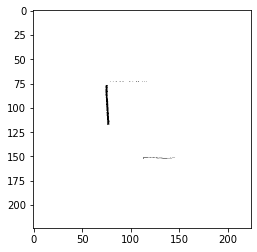

render loss: 0.04105265066027641 mini_loss 0.00012857794354204088
iteration: 30


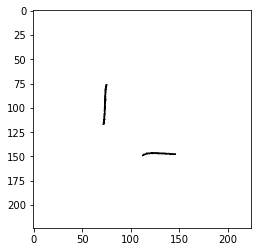

render loss: 0.053421176970005035 mini_loss 0.00019851914839819074
iteration: 40


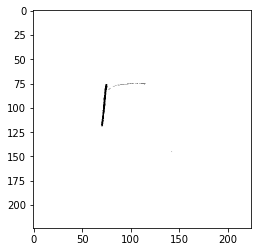

render loss: 0.04460799694061279 mini_loss 0.00011336753232171759
iteration: 50


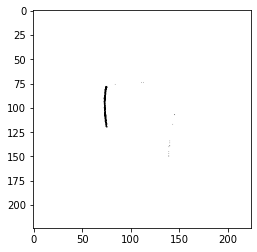

render loss: 0.051130376756191254 mini_loss 0.00010498550545889884
iteration: 60


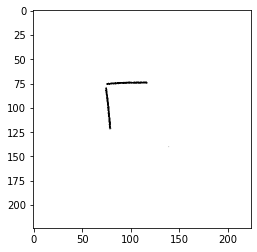

render loss: 0.04118331894278526 mini_loss 0.00019821290334220976
iteration: 70


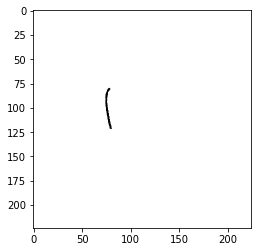

render loss: 0.04627310112118721 mini_loss 0.00010000618203775957
iteration: 80


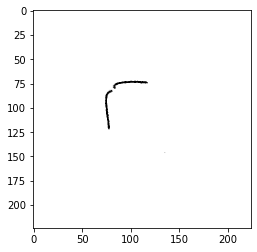

render loss: 0.05095173045992851 mini_loss 0.00020099696121178567
iteration: 90


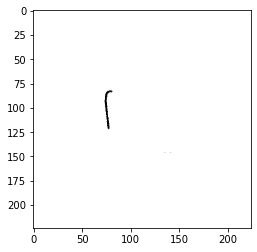

render loss: 0.048197317868471146 mini_loss 0.00010161558020627126
iteration: 100


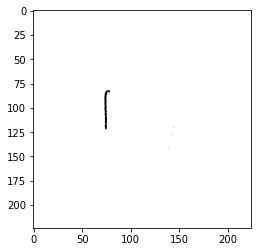

render loss: 0.05140163004398346 mini_loss 0.00010157998622162268


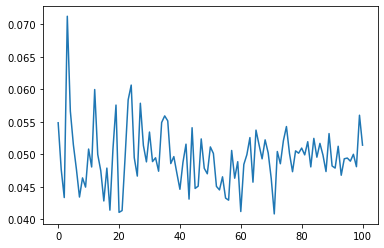

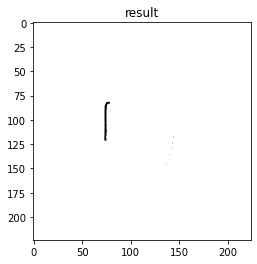

In [259]:
# toy example

random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

im = np.ones((224,224,3))
third = 224 // 3
third_q = third // 5
im[third, third: third * 2] = 0
im[third * 2, third: third * 2] = 0
im[third: third * 2, third] = 0
im[third: third * 2, third * 2] = 0

far_s = third - 30
# imageio.imsave("black_square.png", im)
points_vars = np.array([[[third,third],[third, third + third_q], [third, third + 2 * third_q], [third, third + 3  * third_q]],
                       [[third,third],[third + third_q, third], [third + 2 * third_q, third], [third + 3  * third_q, third]],
                       [[third * 2,third * 2],[third * 2 - third_q, third * 2], [third * 2 - 2 * third_q, third * 2], [third * 2 - 3  * third_q, third * 2]],
                       [[third * 2,third * 2],[third * 2, third * 2 - third_q], [third * 2, third * 2 - 2 * third_q], [third * 2, third * 2 - 3  * third_q]],
                       [[far_s,far_s],[far_s, far_s + third_q], [far_s, far_s + 2 * third_q], [far_s, far_s + 3  * third_q]]])
                        # [],
                        # [],
                        # []])
print(points_vars.shape)
for s in points_vars:
    for p in s:
        im[p[0] - 2 :p[0] + 2 ,p[1] - 2 : p[1] + 2] = (1,0,0)

plt.imshow(im)
plt.show()
target_ = "black_square.png"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex_mask.png"
# path_svg = "/home/vinker/dev/background_project/experiements/05_29_image_divide/easy-background-crop_ViT_l0_32s/easy-background-crop_ViT_l0_32s_seed0/svg_logs/svg_iter0.svg"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/easy-background-crop.jpeg"


# device = torch.device("cuda" if (
#         torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224
num_strokes=5
num_cp=4

target, mask = get_target(target_, device, image_scale=224)
points_vars = torch.tensor(points_vars).unsqueeze(0).to(device)
# # points_vars = get_initial_points(path_svg, target_, device) # list of tensors
# points_vars = get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224)

# points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
print(points_vars.shape)
points_vars = points_vars / canvas_size
# points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

widths = torch.ones(num_strokes)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.detach().cpu().numpy())
plt.show()
mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

mlp_width.apply(init_weights)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)


clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,1,0]
loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)

im = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=0.0001, canvas_size=224, num_strokes=num_strokes, num_cp=4)
plt.imshow(im.detach().cpu().numpy())
plt.title("result")
plt.show()

torch.Size([1, 64, 4, 2])
iteration: 0


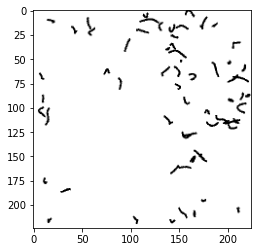

render loss: 0.244384765625
iteration: 50


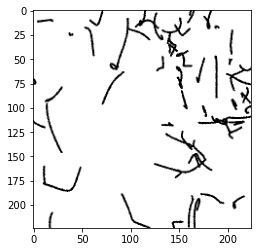

render loss: 0.202392578125
iteration: 100


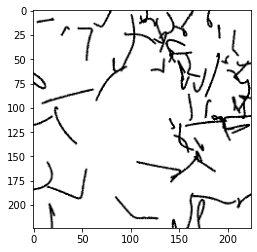

render loss: 0.2071533203125
iteration: 150


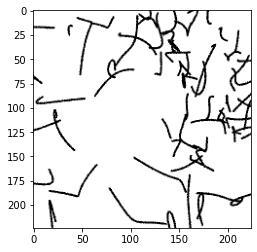

render loss: 0.201171875
iteration: 200


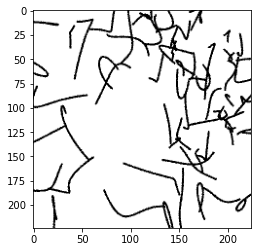

render loss: 0.20849609375
iteration: 250


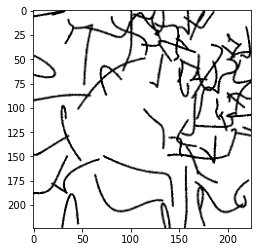

render loss: 0.1842041015625
iteration: 300


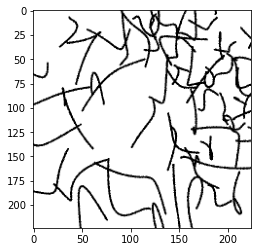

render loss: 0.199951171875
iteration: 350


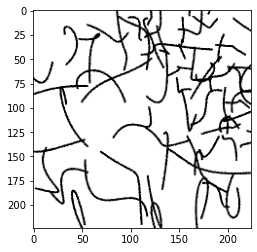

render loss: 0.184814453125
iteration: 400


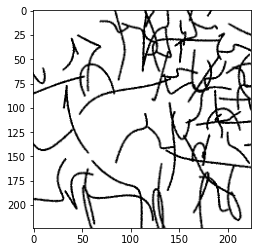

render loss: 0.1888427734375
iteration: 450


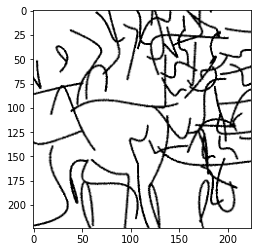

render loss: 0.185302734375
iteration: 500


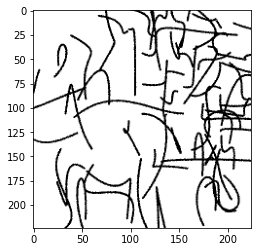

render loss: 0.170654296875
iteration: 550


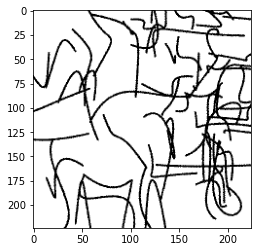

render loss: 0.184814453125
iteration: 600


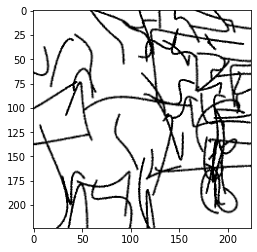

render loss: 0.1590576171875
iteration: 650


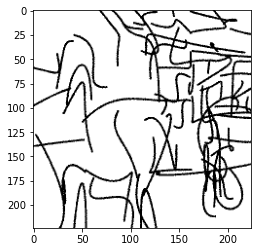

render loss: 0.165283203125
iteration: 700


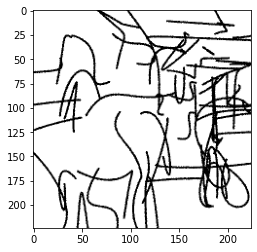

render loss: 0.1766357421875
iteration: 750


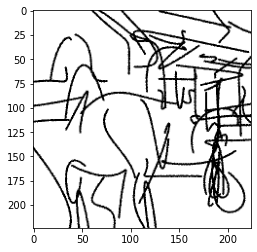

render loss: 0.1611328125
iteration: 800


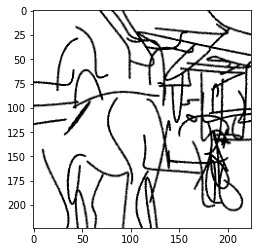

render loss: 0.1683349609375
iteration: 850


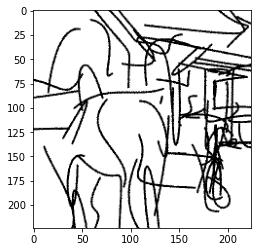

render loss: 0.144287109375
iteration: 900


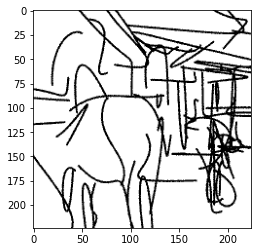

render loss: 0.1507568359375
iteration: 950


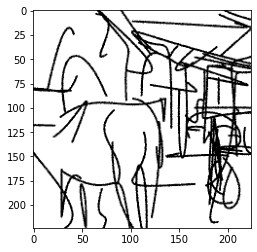

render loss: 0.1619873046875
iteration: 1000


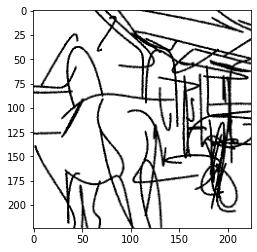

render loss: 0.1575927734375


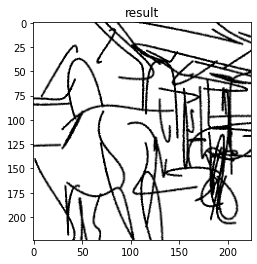

In [42]:
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex_mask.png"
# path_svg = "/home/vinker/dev/background_project/experiements/05_29_image_divide/easy-background-crop_ViT_l0_32s/easy-background-crop_ViT_l0_32s_seed0/svg_logs/svg_iter0.svg"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/easy-background-crop.jpeg"


device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224
num_strokes=64
num_cp=4

target, mask = get_target(target_, device, image_scale=224)

# points_vars = get_initial_points(path_svg, target_, device) # list of tensors
points_vars = get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224)

points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
print(points_vars.shape)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-6)

clip_conv_layer_weights=[0,0,0,1,0,0,0,0,0,0,0,0]
loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)

im = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=0.000001, canvas_size=224, num_strokes=num_strokes, num_cp=4)
plt.imshow(im.detach().cpu().numpy())
plt.title("result")
plt.show()

In [ ]:
#17 #19

In [371]:
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224
num_strokes=4
num_cp=4

target, mask = get_target(target_, device, image_scale=224)

points_vars = get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224)

points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
print(points_vars.shape)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1
print(points_vars.shape)
connect = torch.eye(points_vars.shape[1], points_vars.shape[2]).unsqueeze(0).repeat(1,1,1,1)
print(connect.shape)
print(connect * points_vars)
widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()

torch.Size([1, 4, 4, 2])
torch.Size([1, 4, 4, 2])
torch.Size([1, 1, 4, 4])


RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 3

In [117]:
import torch.nn.functional as F

# random.seed(0)
# np.random.seed(0)
# # os.environ['PYTHONHASHSEED'] = str(seed)
# torch.manual_seed(0)

# edges_logits = self.edges_layer(output)\
#                        .view(-1,self.edges,self.vertexes,self.vertexes)
# edges_logits = (edges_logits + edges_logits.permute(0,1,3,2))/2
# edges_logits = self.dropoout(edges_logits.permute(0,2,3,1))

a_ = torch.rand((16)).view((4,4))#.unsqueeze(0)
print(a_.shape)

a_ = (a_ + a_.permute(0,1,3,2))/2
print(a_.shape)
print(a_[0,0,:,:])

dropoout = nn.Dropout(p=0)
# a_ = dropoout(a_.permute(0,2,3,1))
print(a_.shape)
e_logits = a_
softmax = F.gumbel_softmax(e_logits.contiguous().view(-1,e_logits.size(-1))
                       / 1, hard=True).view(e_logits.size())
print(softmax.shape)
print(softmax[0,:,:,0])
# a_ = a_.unsqueeze(-1).unsqueeze(0)
# print(a_)

# print(a_.size())
# # a = a_ * a_.T
# g = F.gumbel_softmax(a_.contiguous().view(-1, a_.size(-1)) / 1, hard=True).view(a_.size())
# print(g.reshape((1,1,3,3)))
# # v = torch.stack((torch.log(widths_), torch.log(mask_flipped)), dim=-1)
# # # print("v", v)
# # hard_mask = torch.nn.functional.gumbel_softmax(v, 0.8, True)
# # new_mask = hard_mask[:, 0]
# # # print(a)
# # s = nn.Softmax(dim=1)
# # b = s(a)
# # print(b)

torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])
tensor([[0.8853, 0.4713, 0.5994],
        [0.4713, 0.0088, 0.3503],
        [0.5994, 0.3503, 0.7800]])
torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])
tensor([[0., 1., 1.],
        [0., 1., 0.]])


In [184]:
a = torch.rand(4,4)
g = F.gumbel_softmax(a.contiguous() / 1, hard=True).view(a.size())
print(g)
symmetric_g = (g + g.permute(1,0)).clamp(0,1)
print(symmetric_g)

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])
tensor([[1., 0., 1., 1.],
        [0., 0., 1., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.]])


In [ ]:
import math


class MLP2(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # dim = 4
        outdim = dim*dim
        # num_strokes = 32
        self.layers_points = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim * dim, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, dim * dim),
            nn.Sigmoid()
            # nn.Tanh()
        )

    def forward(self, x, widths=None):
        '''Forward pass'''
        return self.layers_points(x)

dim_ = 4
a = torch.rand(dim_, dim_).unsqueeze(0)
print(a)
mlp = MLP2(dim_)
# print(mlp)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4, betas=(0.9, 0.999))

for step in range(5000):
    optimizer.zero_grad()
    mask = mlp(a).view(-1, dim_, dim_)
    g = F.gumbel_softmax(mask.contiguous() / 1, hard=False).view(a.size())
    # print(g)
    symmetric_g = g
    sum_ = symmetric_g.sum(dim=1)#.clamp(0,1)
    loss = ((sum_ - torch.ones(sum_.shape)) ** 2).sum()
    if step % 100 == 0:
        print(symmetric_g)
        print(sum_)
        print("loss", loss.item())
        
    
#     print()
    loss.backward()
    optimizer.step()


mask = mlp(a).view(-1, dim_, dim_)
g = F.gumbel_softmax(mask.contiguous() / 1, hard=True).view(a.size())
print(g)

# print(c)
# sum_ = c.sum(dim=1)
# print(sum_)

# print(loss)

# loss = torch.max(sum_ - 2, torch.zeros(sum_.shape))

In [169]:
sum_ = torch.ones(4)
sum_[0] = 0
sum_[1] = 1
sum_[2] = 2
sum_[3] = 2
print(sum_)
loss = torch.max(sum_ - 2, torch.zeros(sum_.shape))
print(loss)

tensor([0., 1., 2., 2.])
tensor([0., 0., 0., 0.])


In [136]:
a = torch.rand(4,4)
g = F.gumbel_softmax(a.contiguous().view(-1, a.size(-1)) / 1, hard=True).view(a.size())
b = torch.ones(4,4)
b.fill_diagonal_(0.5)
c = g + g.T
print(g)
print(g.T)
print()
print(c)
print(c * b)

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])
tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

tensor([[0., 1., 0., 0.],
        [1., 2., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])
tensor([[0., 1., 0., 0.],
        [1., 1., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])


In [217]:
import torch
torch.__version__

torch.random.manual_seed (2021)

nOrt = 500
nBatch = 30   # not enough rotated vectors to recover 500x500 rho

nEpoch = 1000
nFreq = 100

# make a batch of random vectors
X = torch.rand (nBatch, nOrt)

print ('X.shape =', X.shape)

# make a random orthogonal matrix with determinant +1
rho = torch.nn.init.orthogonal_ (torch.empty (nOrt, nOrt))
if  torch.slogdet (rho)[0] < 0.0:
    rho *= -1   # flip determinant -- assumes that rho is odd-dimensional

# the target vector will be the rotated X
# note that X is right-multiplied by rho
# this will cause model.weight to train to match rho.T, rather than rho itself
X_target = X @ rho

# the model is simply a single Linear layer (with bias)
model = torch.nn.Linear (nOrt, nOrt)
# initialize model.weight to another orthogonal matrix with determinant +1 to match det (rho)
wInit = torch.nn.init.orthogonal_ (torch.empty (nOrt, nOrt))
if  torch.slogdet (wInit)[0] < 0.0:
    wInit *= -1   # flip determinant -- assumes that wInit is odd-dimensional

with torch.no_grad():
    _ = model.weight.copy_ (wInit)

optimizer = torch.optim.Adam (model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss (reduction='sum')

# reg = 0.001   # weight orthogonality-penalty much more heavily
reg = 1000.0
for t in range (nEpoch):
    # param = model.weight.data   # breaks computation graph --  model.weight not optimized
    param = model.weight
    sym = torch.mm (param, torch.t (param))
    sym -= torch.eye (param.shape[0])
    # ls_ort = sym.abs().sum()   # poor match to geometry of orthogonal matrices
    ls_ort = sym.pow (2.0).sum()
    ls_fit = loss_fn (model(X), X_target)
    ls_tot = ls_fit + reg * ls_ort
    with torch.no_grad():
        ldet = torch.slogdet (param)[1]
    optimizer.zero_grad()
    ls_tot.backward()
    optimizer.step()
    if t <= 10  or  t % nFreq == 0  or  t >= nEpoch - 1:
        print ('epoch:{:4d}'.format (t), ' ls_tot:{:9.3f}'.format (float (ls_tot)), ' ls_fit:{:9.3f}'.format (float (ls_fit)), ' ls_ort: {:.2e}'.format (float (ls_ort)), ' ldet: {: .1e}'.format (float (ldet)))

# check rho and model.weight determinants
print ('slogdet (rho)    =  {: 1.0f}  {: .3e}'.format (torch.slogdet (rho)[0], torch.slogdet(rho)[1]))
print ('slogdet (param)  =  {: 1.0f}  {: .3e}'.format (torch.slogdet (param)[0], torch.slogdet(param)[1]))

# check fit of model.weight to rho
with torch.no_grad():
    fit = (param - rho).abs().sum()
    fitT = (param - rho.T).abs().sum()

print ('fit = {:13.5f}, fitT = {:13.5f}'.format (fit, fitT))
print(rho)
print(param)

X.shape = torch.Size([30, 500])
epoch:   0  ls_tot: 9968.365  ls_fit: 9968.365  ls_ort: 2.42e-10  ldet:  1.1e-05
epoch:   1  ls_tot: 6984.130  ls_fit: 6536.736  ls_ort: 4.47e-01  ldet: -4.1e-01
epoch:   2  ls_tot: 5456.405  ls_fit: 4554.479  ls_ort: 9.02e-01  ldet: -9.2e-01
epoch:   3  ls_tot: 4708.714  ls_fit: 3511.573  ls_ort: 1.20e+00  ldet: -1.4e+00
epoch:   4  ls_tot: 4356.467  ls_fit: 3003.019  ls_ort: 1.35e+00  ldet: -1.8e+00
epoch:   5  ls_tot: 4166.570  ls_fit: 2764.879  ls_ort: 1.40e+00  ldet: -2.1e+00
epoch:   6  ls_tot: 4033.207  ls_fit: 2654.856  ls_ort: 1.38e+00  ldet: -2.1e+00
epoch:   7  ls_tot: 3915.477  ls_fit: 2601.749  ls_ort: 1.31e+00  ldet: -1.9e+00
epoch:   8  ls_tot: 3786.879  ls_fit: 2565.707  ls_ort: 1.22e+00  ldet: -1.7e+00
epoch:   9  ls_tot: 3633.864  ls_fit: 2528.301  ls_ort: 1.11e+00  ldet: -1.4e+00
epoch:  10  ls_tot: 3459.893  ls_fit: 2488.102  ls_ort: 9.72e-01  ldet: -1.2e+00
epoch: 100  ls_tot:  633.859  ls_fit:  630.421  ls_ort: 3.44e-03  ldet: -6.8e

In [228]:
dim = 2
weights = torch.eye(dim * 2, dim * 2)
print(weights)
points = torch.rand(dim * dim)
points_dest = torch.rand(dim * dim)
g = F.gumbel_softmax(points.contiguous() / 1, hard=True)
print(g)
points_dest[g == 1] = -math.inf
g_dest = F.gumbel_softmax(points_dest.contiguous() / 1, hard=True)
print(g_dest)
weights[g == 1, g_dest == 1] = 1
weights[g_dest == 1, g == 1] = 1
print(weights)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
tensor([0., 1., 0., 0.])
tensor([1., 0., 0., 0.])
tensor([[1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


torch.Size([3, 6])
tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([1., 1., 1., 1., 2., 0.], device='cuda:0')


/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 3, 4, 2])
all_points tensor(224., device='cuda:0') tensor(0., device='cuda:0')


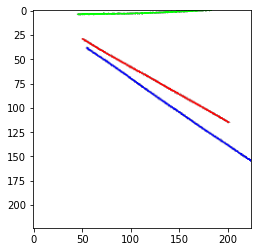

points_vars torch.Size([1, 3, 4, 2])
lefts torch.Size([1, 3, 2])
edge_points torch.Size([1, 6, 2])
connect torch.Size([1, 6, 6])
new_edge_points torch.Size([1, 6, 2])
all_points tensor(224., device='cuda:0') tensor(3.6432, device='cuda:0')


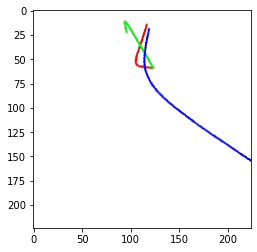

In [7]:
def render_points(points, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    colors = [[1,0,0,1], [0,1,0,1], [0,0,1,1]]
    all_points = 0.5 * (points + 1.0) * canvas_size
    print("all_points", all_points.max(), all_points.min())
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        width = torch.tensor(1.0)
        if widths is not None:
            width = widths[p]
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=width, is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor(colors[p]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img



num_strokes=3

n = num_strokes * 2
shift_matrix = torch.rand((n // 2, n))
print(shift_matrix.shape)
g = F.gumbel_softmax(shift_matrix.contiguous() / 1, hard=True)
# print(g)
g_flip = g.flip(0).flip(1)
# print(g_flip)
adj_mat = torch.cat([g, g_flip], dim=0).to(device)
adj_mat = torch.tensor([
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')
print(adj_mat)
print(adj_mat.sum(dim=0))

random.seed(2)
np.random.seed(2)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(2)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224

num_cp=4

target, mask = get_target(target_, device, image_scale=224)

points_vars = get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224)

points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
points_vars[:,:,0,:] = points_vars[:,:,0,:] / 2
points_vars[:,:,-1,:] = points_vars[:,:,-1,:] * 2
print(points_vars.shape)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2 * points_vars - 1

widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()



print("points_vars",points_vars.shape)

lefts = points_vars[:,:,0,:]
print("lefts",lefts.shape)
edge_points = torch.cat([points_vars[:,:,0,:], points_vars[:,:,-1,:]], dim=1)
print("edge_points", edge_points.shape)

connect = torch.eye(num_strokes * 2, num_strokes * 2).unsqueeze(0).to(device)
# connect[0,0,0] = 0
# connect[0,0,0] = 1
print("connect", connect.shape)

new_edge_points = (torch.matmul(adj_mat, edge_points) + edge_points) / (adj_mat.sum(dim=1).unsqueeze(0).unsqueeze(-1) + 1)
print("new_edge_points", new_edge_points.shape)

points_vars[:,:,0,:] = new_edge_points[:,:num_strokes,:]
points_vars[:,:,-1,:] = new_edge_points[:,num_strokes:,:]
# y_ = torch.matmul(connect, points_vars[:,:,:,1])
# print("x_", x_.shape)
# points_vars = torch.cat([x_,y_], dim=0).permute(1,2,0).unsqueeze(0)
# print(torch.eq(res, points_vars))

widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()


# shift_inds_bin = torch.arange(n).T.unsqueeze(1)#.repeat(n // 2,1).T
# print(shift_inds_bin)
# shift_inds = torch.mm(g.type(torch.FloatTensor), shift_inds_bin.type(torch.FloatTensor)).squeeze() - shift_inds_bin.T
# print(shift_inds)
# shift_inds = torch.cat([shift_inds, -shift_inds.flip(0)]).T.squeeze()
# print(shift_inds, shift_inds.shape)

# eye = torch.eye(n)
# for row,x in zip(eye, shift_inds):
#     print(row, x)
#     print(torch.roll(row, int(x.item())).unsqueeze(0))
#     print()
# c = torch.cat([torch.roll(row, int(x.item())).unsqueeze(0) for row,x in zip(eye, shift_inds)])
# print(c)

In [272]:
a = torch.eye(4)
# print(a)
b = torch.roll(a, shifts=(0, 1), dims=(0, 1))
r = torch.tensor([0,1,-1,-1])

print(a)
print(r)
c = torch.cat([torch.roll(row, x.item()).unsqueeze(0) for row,x in zip(a, r)])
print(c)
b = torch.roll(a, shifts=(1, 0), dims=(0, 1))
print()
print(b)

tensor(0)
tensor(1)
tensor(-1)
tensor(-1)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
tensor([ 0,  1, -1, -1])
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])

tensor([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])


In [344]:
a = torch.arange(20).view(5,4)
print(a)
b = 

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])
